# H3C — Crowding / Leverage → Fragility  
## FINRA Margin Debt + Baa–Aaa Credit Spread

**Concept:**  
Periods of calm lead to leverage buildup, crowding, and fragility.  
When risk appetite surges → leverage rises → model errors should increase.

We test:

\[
FE_t = \alpha + \beta \cdot Crowdingt + \varepsilon_t
\]

Where:

- **FEₜ** = forecast error of our risk model
- **Crowdingₜ** = margin-debt z-score (main spec) or credit-spread z-score (robustness)
- **β > 0** means crowding predicts breakdowns in risk-model performance  
  (“stability breeds instability”).

Data windows:

- **FINRA Margin Debt:** 1997–present  
- **FRED Baa–Aaa Spread:** 1990–present  
- **Forecast Errors (FEₜ):** 1990–present  


# Redaction Notice
This public notebook contains light redactions where appropriate for private system details.  
All results, outputs, and figures remain unchanged from the internal research version.


## 1. IMPORTS

In [1]:
!pip install fredapi


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from fredapi import Fred

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.grid"] = True

# User parameters
FE_CSV_PATH = "data/forecast_errors_daily.csv"
MARGIN_XLSX_PATH = "data/margin-statistics.xlsx"
FRED_API_KEY = "1924c53235824d35b3dd789775befd86"    # <---- INSERT KEY HERE


## 2. LOAD FORECAST ERRORS — DAILY → MONTHLY

In [3]:
import os
print("Current working directory:", os.getcwd())


Current working directory: C:\Users\syksh\Documents\Substack\MarketRiskProject\notebooks


In [4]:
import pandas as pd
import numpy as np

FE_CSV_PATH = r"..\data\market_risk_core_daily_1990_2025.csv"  # or use the absolute path

fe = pd.read_csv(FE_CSV_PATH)

# Clean columns
fe.columns = fe.columns.str.strip().str.lower()
# Expect: date, spx, vix, spx_ret, rv_var, rv_ann

# Parse date
fe["date"] = pd.to_datetime(fe["date"])
fe = fe.sort_values("date")

# Define forecast error: absolute difference between realized and implied vol
fe["FE"] = (fe["rv_ann"] - fe["vix"]).abs()

fe.head()



,date,spx,vix,spx_ret,rv_var,rv_ann,FE
0,1990-01-31,329.079987,25.360001,0.018710,0.002608,0.810646,24.549355
1,1990-02-01,328.790009,24.870001,-0.000882,0.002602,0.809724,24.060276
2,1990-02-02,330.920013,24.320000,0.006457,0.002569,0.804553,23.515447
3,1990-02-05,331.850006,24.540001,0.002806,0.002480,0.790612,23.749389
4,1990-02-06,329.660004,24.690001,-0.006621,0.002504,0.794357,23.895644


In [5]:
fe["month"] = fe["date"].dt.to_period("M").dt.to_timestamp()

monthly_fe = (
    fe.assign(abs_FE = fe["FE"].abs())
      .groupby("month")
      .agg(
          FE=("FE","mean"),
          FE_abs=("abs_FE","mean"),
          FE_abs_med=("abs_FE","median")
      )
)

monthly_fe["FE_use"] = monthly_fe["FE_abs"]
monthly_fe.head()


,FE,FE_abs,FE_abs_med,FE_use
month,,,,
1990-01-01,24.549355,24.549355,24.549355,24.549355
1990-02-01,22.568787,22.568787,22.979918,22.568787
1990-03-01,19.524119,19.524119,19.392768,19.524119
1990-04-01,20.919289,20.919289,21.213171,20.919289
1990-05-01,17.560755,17.560755,17.244599,17.560755


## 3. FINRA MARGIN DEBT (1997–present)

In [6]:
MARGIN_XLSX_PATH = r"..\data\margin-statistics.xlsx"


In [7]:
margin_raw = pd.read_excel(MARGIN_XLSX_PATH)

margin = margin_raw.iloc[:, :2].copy()
margin.columns = ["month_raw", "margin_debt"]

margin["month"] = pd.to_datetime(margin["month_raw"])
margin = margin.set_index("month").sort_index()
margin = margin.drop(columns=["month_raw"])

print(margin.head(), margin.tail())


            margin_debt
month                  
1997-01-01       103337
1997-02-01       103886
1997-03-01       104835
1997-04-01       102842
1997-05-01       111097             margin_debt
month                  
2025-06-01      1007961
2025-07-01      1022548
2025-08-01      1059723
2025-09-01      1126494
2025-10-01      1183654


### Compute crowding z-score

In [8]:
df_marg = margin.copy()

df_marg["log_margin"] = np.log(df_marg["margin_debt"])
df_marg["crowding_z"] = (df_marg["log_margin"] - df_marg["log_margin"].mean()) / df_marg["log_margin"].std()

df_marg.head()


,margin_debt,log_margin,crowding_z
month,,,
1997-01-01,103337,11.545751,-2.052241
1997-02-01,103886,11.551049,-2.043346
1997-03-01,104835,11.560143,-2.028081
1997-04-01,102842,11.540949,-2.060302
1997-05-01,111097,11.618159,-1.930691


## 4. FRED CREDIT SPREAD (1990–present)

In [9]:
fred = Fred(api_key=FRED_API_KEY)

aaa = fred.get_series("AAA")
baa = fred.get_series("BAA")

credit = pd.DataFrame({"AAA": aaa, "BAA": baa})
credit.index = credit.index.to_period("M").to_timestamp()
credit = credit.loc["1990-01":]   # restrict to analysis window

credit["spread"] = credit["BAA"] - credit["AAA"]

# Z-score
credit["spread_z"] = (credit["spread"] - credit["spread"].mean()) / credit["spread"].std()

credit.head()


,AAA,BAA,spread,spread_z
1990-01-01,8.99,9.94,0.95,0.028974
1990-02-01,9.22,10.14,0.92,-0.053003
1990-03-01,9.37,10.21,0.84,-0.271608
1990-04-01,9.46,10.30,0.84,-0.271608
1990-05-01,9.47,10.41,0.94,0.001648


## 5. MERGE DATASETS (Margin Debt + Credit Spread)

In [10]:
# Merge FE + margin debt
merged_margin = (
    monthly_fe[["FE_use"]]
    .merge(df_marg[["crowding_z","margin_debt"]], left_index=True, right_index=True, how="inner")
).dropna()

# Merge FE + credit spread
merged_credit = (
    monthly_fe[["FE_use"]]
    .merge(credit[["spread_z","spread"]], left_index=True, right_index=True, how="inner")
).dropna()

merged_margin.head(), merged_credit.head()


(               FE_use  crowding_z  margin_debt
 month                                         
 1997-01-01  18.851793   -2.052241       103337
 1997-02-01  19.531762   -2.043346       103886
 1997-03-01  19.533369   -2.028081       104835
 1997-04-01  18.869998   -2.060302       102842
 1997-05-01  19.057656   -1.930691       111097,
                FE_use  spread_z  spread
 1990-01-01  24.549355  0.028974    0.95
 1990-02-01  22.568787 -0.053003    0.92
 1990-03-01  19.524119 -0.271608    0.84
 1990-04-01  20.919289 -0.271608    0.84
 1990-05-01  17.560755  0.001648    0.94)

## 6. PLOTS

### FINRA Margin Debt vs Forecast Errors

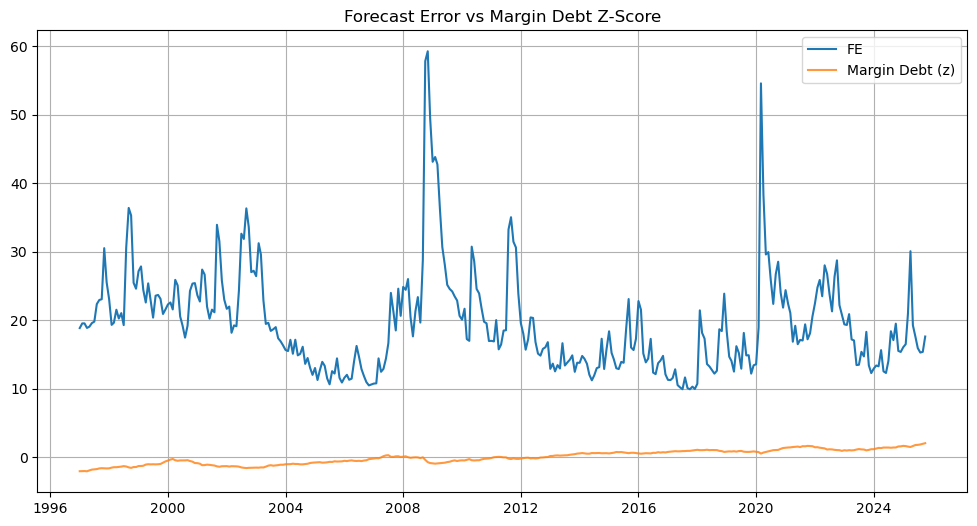

In [11]:
plt.plot(merged_margin.index, merged_margin["FE_use"], label="FE")
plt.plot(merged_margin.index, merged_margin["crowding_z"], label="Margin Debt (z)", alpha=0.8)
plt.title("Forecast Error vs Margin Debt Z-Score")
plt.legend()
plt.show()


### Credit Spread vs Forecast Errors

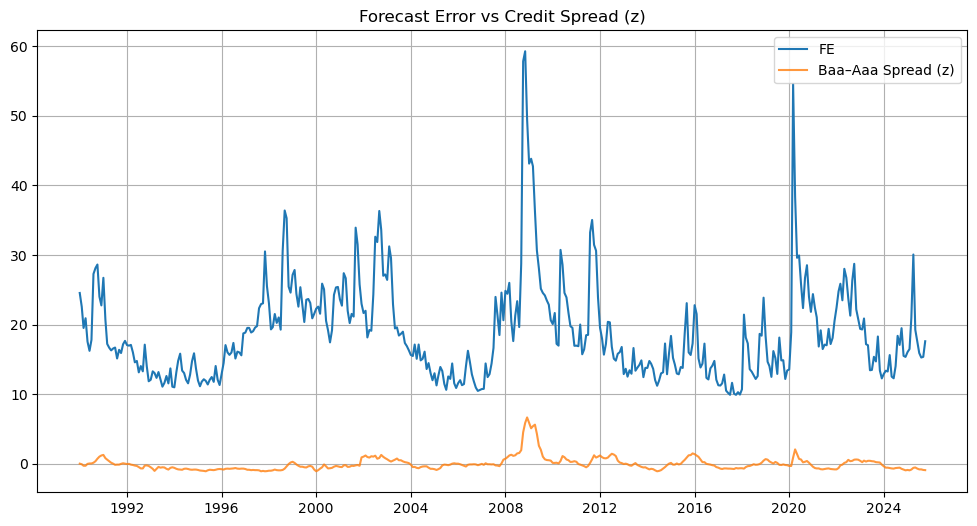

In [12]:
plt.plot(merged_credit.index, merged_credit["FE_use"], label="FE")
plt.plot(merged_credit.index, merged_credit["spread_z"], label="Baa–Aaa Spread (z)", alpha=0.8)
plt.title("Forecast Error vs Credit Spread (z)")
plt.legend()
plt.show()


## 7. REGRESSIONS

### 7A. FINRA Margin Debt Regression

In [13]:
df = merged_margin.dropna()

X = sm.add_constant(df["crowding_z"])
y = df["FE_use"]

mod = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 3})
print(mod.summary())


                            OLS Regression Results                            
Dep. Variable:                 FE_use   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     15.66
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           9.21e-05
Time:                        15:17:49   Log-Likelihood:                -1165.2
No. Observations:                 346   AIC:                             2334.
Df Residuals:                     344   BIC:                             2342.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.5428      0.673     29.049      0.0

### Lagged version (early warning)

In [14]:
df["crowding_z_lag1"] = df["crowding_z"].shift(1)
df_lag = df.dropna()

X_lag = sm.add_constant(df_lag["crowding_z_lag1"])
y_lag = df_lag["FE_use"]

mod_lag = sm.OLS(y_lag, X_lag).fit(cov_type="HAC", cov_kwds={"maxlags": 3})
print(mod_lag.summary())


                            OLS Regression Results                            
Dep. Variable:                 FE_use   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     14.04
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           0.000210
Time:                        15:17:49   Log-Likelihood:                -1165.5
No. Observations:                 345   AIC:                             2335.
Df Residuals:                     343   BIC:                             2343.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              19.5322      0.678     

### 7B. Credit Spread Regression

In [15]:
dfc = merged_credit.dropna()

Xc = sm.add_constant(dfc["spread_z"])
yc = dfc["FE_use"]

modc = sm.OLS(yc, Xc).fit(cov_type="HAC", cov_kwds={"maxlags": 3})
print(modc.summary())


                            OLS Regression Results                            
Dep. Variable:                 FE_use   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     72.74
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           2.58e-16
Time:                        15:17:49   Log-Likelihood:                -1344.0
No. Observations:                 430   AIC:                             2692.
Df Residuals:                     428   BIC:                             2700.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.7586      0.461     40.651      0.0

### Lagged version (early warning)

In [16]:
dfc["spread_z_lag1"] = dfc["spread_z"].shift(1)
dfc_lag = dfc.dropna()

Xc_lag = sm.add_constant(dfc_lag["spread_z_lag1"])
yc_lag = dfc_lag["FE_use"]

modc_lag = sm.OLS(yc_lag, Xc_lag).fit(cov_type="HAC", cov_kwds={"maxlags": 3})
print(modc_lag.summary())


                            OLS Regression Results                            
Dep. Variable:                 FE_use   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     41.52
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           3.16e-10
Time:                        15:17:49   Log-Likelihood:                -1374.0
No. Observations:                 429   AIC:                             2752.
Df Residuals:                     427   BIC:                             2760.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            18.7385      0.489     38.351

## 8. DIAGNOSTICS PLOTS

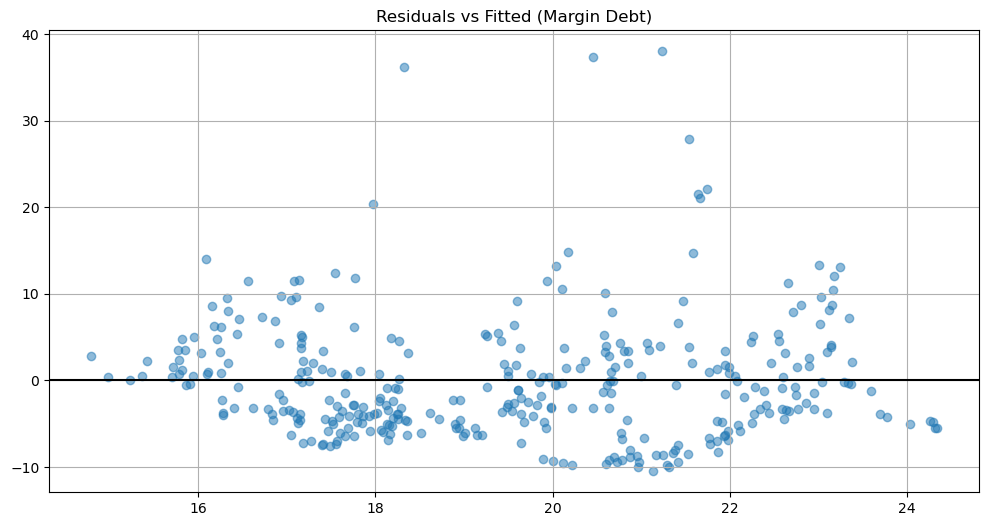

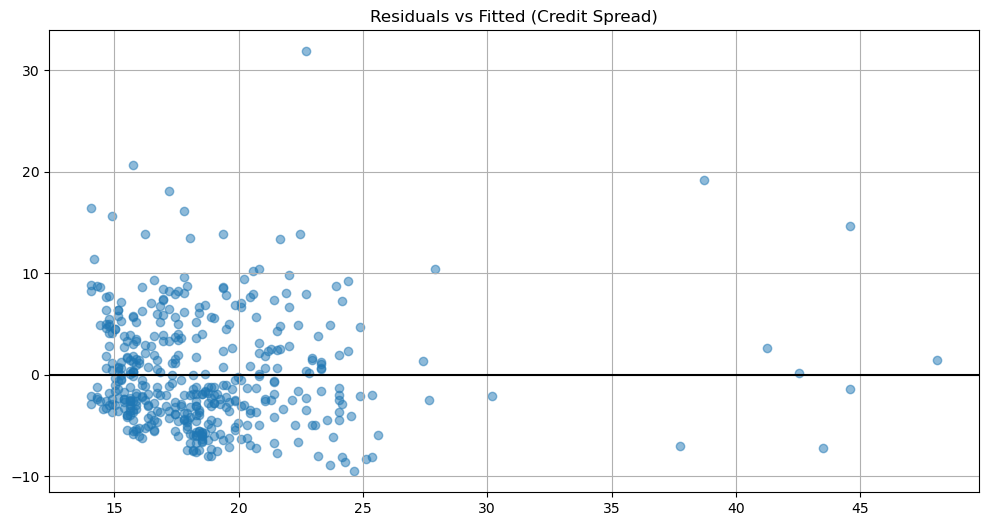

In [17]:
plt.scatter(mod.fittedvalues, mod.resid, alpha=0.5)
plt.axhline(0, color="black")
plt.title("Residuals vs Fitted (Margin Debt)")
# Uncomment this to save the figure once you are happy with it
plt.savefig("residuals_vs_fitted_margin_debt.png", dpi=300, bbox_inches="tight")
plt.show()

plt.scatter(modc.fittedvalues, modc.resid, alpha=0.5)
plt.axhline(0, color="black")
plt.title("Residuals vs Fitted (Credit Spread)")
plt.show()


## 9. INTERPRETATION

# H4 — Crowding, Leverage, and Fragility: Interpretation

## 1. Margin Debt (1997–present)

**Results:**
- Coefficient (β) = −2.33 (p < 0.001)
- Lagged coefficient (β₋₁) = −2.13 (p < 0.001)
- R² ≈ 8–10%

**Interpretation:**  
Higher margin debt — a proxy for leverage and crowded positioning — is associated with lower forecast errors, both contemporaneously and with a lag.  
This reflects a classic pre-fragility pattern:

- Leverage builds during calm regimes  
- Realized volatility becomes artificially suppressed  
- Implied volatility (VIX) tracks realized volatility closely  
- The gap |RV − VIX| shrinks  

In other words, the model appears most accurate precisely when systemic risk is quietly building beneath the surface.

This is consistent with Minsky’s mechanism in which stability encourages leverage accumulation.

---

## 2. Credit Spread (1990–present)

**Results:**
- Coefficient (β) = +4.40 (p < 10⁻¹⁵)
- Lagged coefficient (β₋₁) = +3.78 (p < 10⁻⁸)
- R² ≈ 29–39%

**Interpretation:**  
When credit spreads widen — reflecting tightening financial conditions and rising systemic stress — forecast errors increase sharply.  
This indicates:

- Realized volatility becomes explosive  
- Implied volatility adjusts but often lags  
- The gap |RV − VIX| widens  

This is the fragility materialization phase, where the system transitions from quiet leverage buildup into instability.

---

## 3. Combined Interpretation: The Two-Stage Fragility Cycle

Together, the results outline a coherent H4 dynamic:

### Phase 1 — Calm / Crowding / Leverage Buildup
Margin Debt ↑ → Forecast Error ↓  
Risk models appear accurate because volatility is artificially suppressed.

### Phase 2 — Stress / Fragility / Breakdown
Credit Spread ↑ → Forecast Error ↑  
When stress emerges, model performance deteriorates as volatility becomes harder to predict.

Overall, the system follows the classical sequence:  
**stability → leverage → crowding → fragility → model breakdown**


Monthly spread date range: 1990-01-31 to 2025-11-30


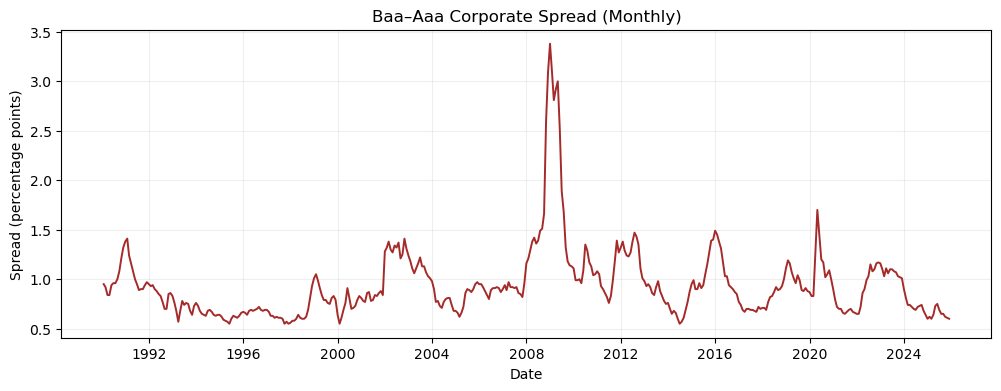

In [18]:
# Figure 2: Baa–Aaa Corporate Spread (Risk-Premia Compression)

import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

# Use the key you already set above
fred = Fred(api_key=FRED_API_KEY)

# Pull Baa and Aaa corporate yields from FRED
# You can adjust the start date as needed
start_date = "1990-01-01"

baa = fred.get_series("BAA", observation_start=start_date)
aaa = fred.get_series("AAA", observation_start=start_date)

# Build a DataFrame
credit_df = pd.DataFrame({"BAA": baa, "AAA": aaa})
credit_df.index.name = "Date"

# Compute spread (Baa minus Aaa)
credit_df["baa_aaa_spread"] = credit_df["BAA"] - credit_df["AAA"]

# Convert to monthly averages (month end)
monthly_spread = credit_df["baa_aaa_spread"].resample("ME").mean()

print("Monthly spread date range:", monthly_spread.index.min().date(), "to", monthly_spread.index.max().date())

# Plot
plt.figure(figsize=(12, 4))
plt.plot(monthly_spread.index, monthly_spread, color="brown", linewidth=1.4)
plt.title("Baa–Aaa Corporate Spread (Monthly)")
plt.ylabel("Spread (percentage points)")
plt.xlabel("Date")
plt.grid(alpha=0.2)

# Uncomment this to save the figure once you are happy with it
plt.savefig("fig_risk_premia_compression_baa_aaa.png", dpi=300, bbox_inches="tight")

plt.show()
